In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder(root='Combined Dataset/train', transform=transform)
train_size = int(0.6 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

In [5]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [6]:
test_dataset = datasets.ImageFolder(root='Combined Dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class AlzheimerModel(nn.Module):
    def __init__(self):
        super(AlzheimerModel, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1280, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 4)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerModel().to(device)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:04<00:00, 5.23MB/s]


In [9]:
print(device)

cuda


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

In [11]:
epochs = 10
early_stop_count = 0
best_val_loss = np.inf
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_acc = correct / total
    val_loss /= len(val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
        best_model = model.state_dict()
    else:
        early_stop_count += 1
        if early_stop_count >= 5:
            print("Early stopping triggered.")
            break

Epoch 1/10, Train Loss: 0.5119, Train Acc: 0.7736, Val Loss: 0.3701, Val Acc: 0.8481
Epoch 2/10, Train Loss: 0.2964, Train Acc: 0.8840, Val Loss: 0.2244, Val Acc: 0.9094
Epoch 3/10, Train Loss: 0.1391, Train Acc: 0.9461, Val Loss: 0.2043, Val Acc: 0.9248
Epoch 4/10, Train Loss: 0.0840, Train Acc: 0.9707, Val Loss: 0.1583, Val Acc: 0.9453
Epoch 5/10, Train Loss: 0.0655, Train Acc: 0.9780, Val Loss: 0.1351, Val Acc: 0.9548
Epoch 6/10, Train Loss: 0.0492, Train Acc: 0.9829, Val Loss: 0.1539, Val Acc: 0.9492
Epoch 7/10, Train Loss: 0.0440, Train Acc: 0.9847, Val Loss: 0.1384, Val Acc: 0.9568
Epoch 8/10, Train Loss: 0.0284, Train Acc: 0.9915, Val Loss: 0.1713, Val Acc: 0.9456
Epoch 9/10, Train Loss: 0.0302, Train Acc: 0.9893, Val Loss: 0.1507, Val Acc: 0.9553
Epoch 10/10, Train Loss: 0.0321, Train Acc: 0.9893, Val Loss: 0.0961, Val Acc: 0.9683


In [25]:
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}, Final Train Acc: {history['train_acc'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}, Final Val Acc: {history['val_acc'][-1]:.4f}")

Final Train Loss: 0.0321, Final Train Acc: 0.9893
Final Val Loss: 0.0961, Final Val Acc: 0.9683


In [26]:
torch.save(model.state_dict(), 'alzheimer_model.pth')

In [14]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9367


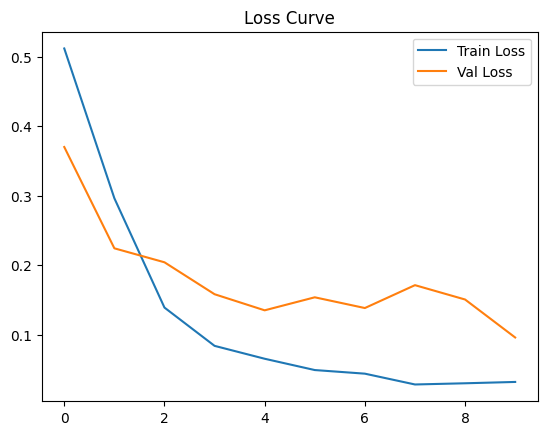

In [15]:
plt.figure()
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

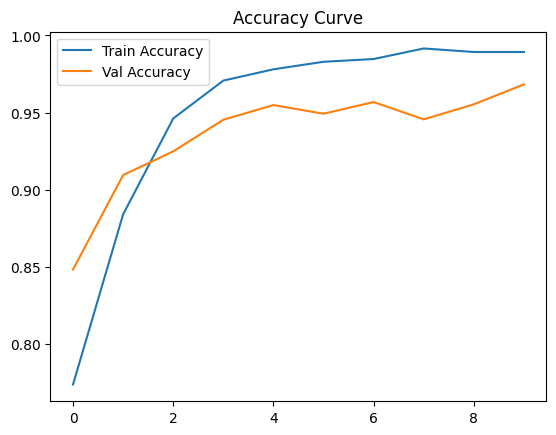

In [ ]:
plt.figure()
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy Curve') 
plt.legend()
plt.show()